In [1]:

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA,COBYLA,SLSQP
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
import numpy as np
import copy

from qiskit_optimization.algorithms import CobylaOptimizer
# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

In [2]:
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

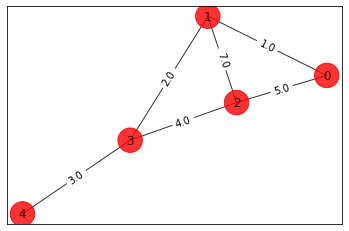

In [3]:
# Generating a graph of 4 nodes 

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,5.0),(1,2,7.0),(3,2,4.0),(1,3,2.0),(3,4,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 5. 0. 0.]
 [1. 0. 7. 2. 0.]
 [5. 7. 0. 4. 0.]
 [0. 2. 4. 0. 3.]
 [0. 0. 0. 3. 0.]]


case = [0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 0, 0, 0] cost = 10.0
case = [1, 1, 0, 0, 0] cost = 14.0
case = [0, 0, 1, 0, 0] cost = 16.0
case = [1, 0, 1, 0, 0] cost = 12.0
case = [0, 1, 1, 0, 0] cost = 12.0
case = [1, 1, 1, 0, 0] cost = 6.0
case = [0, 0, 0, 1, 0] cost = 9.0
case = [1, 0, 0, 1, 0] cost = 15.0
case = [0, 1, 0, 1, 0] cost = 15.0
case = [1, 1, 0, 1, 0] cost = 19.0
case = [0, 0, 1, 1, 0] cost = 17.0
case = [1, 0, 1, 1, 0] cost = 13.0
case = [0, 1, 1, 1, 0] cost = 9.0
case = [1, 1, 1, 1, 0] cost = 3.0
case = [0, 0, 0, 0, 1] cost = 3.0
case = [1, 0, 0, 0, 1] cost = 9.0
case = [0, 1, 0, 0, 1] cost = 13.0
case = [1, 1, 0, 0, 1] cost = 17.0
case = [0, 0, 1, 0, 1] cost = 19.0
case = [1, 0, 1, 0, 1] cost = 15.0
case = [0, 1, 1, 0, 1] cost = 15.0
case = [1, 1, 1, 0, 1] cost = 9.0
case = [0, 0, 0, 1, 1] cost = 6.0
case = [1, 0, 0, 1, 1] cost = 12.0
case = [0, 1, 0, 1, 1] cost = 12.0
case = [1, 1, 0, 1, 1] cost = 16.0
case = [0, 0, 1, 1, 1] cost = 

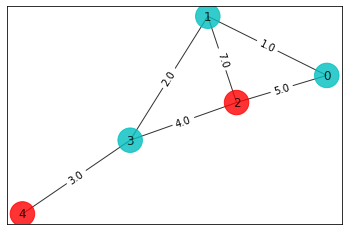

In [5]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))    

In [6]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qp.to_docplex().prettyprint()
#CplexOptimizer().solve(qp)

// This file has been generated by DOcplex
// model name is: Max-cut
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

maximize
 6 x_0 + 10 x_1 + 16 x_2 + 9 x_3 + 3 x_4 [ - 2 x_0*x_1 - 10 x_0*x_2
 - 14 x_1*x_2 - 4 x_1*x_3 - 8 x_2*x_3 - 6 x_3*x_4 ];
 
subject to {

}


In [7]:
def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem





#qubitOp, offset = qp.to_ising()
#print('Offset:', offset)
#print('Ising Hamiltonian:')
#print(str(qubitOp))

In [8]:
#from qiskit_optimization.converters import LinearEqualityToPenalty

In [9]:
#lineq2penalty = LinearEqualityToPenalty()
#qubo1 = lineq2penalty.convert(qp)
#print(qubo1.export_as_lp_string())

In [10]:
CplexOptimizer().solve(qp)

optimal function value: 19.0
optimal value: [1. 1. 0. 1. 0.]
status: SUCCESS

In [11]:
qp1 = relax_problem(QuadraticProgramToQubo().convert(qp))
qp1
#exact1 = MinimumEigenOptimizer(NumPyMinimumEigensolver())
#result1 = exact1.solve(qp1)
#print(result1)
optimizer = CobylaOptimizer()
result = optimizer.solve(qp1) 
result

optimal function value: 19.0
optimal value: [1. 1. 0. 1. 0.]
status: SUCCESS

In [12]:
c_stars = result.samples[0].x
c_stars

array([1., 1., 0., 1., 0.])

In [13]:
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   seed_simulator=algorithm_globals.random_seed,
                                   seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
exact_mes = NumPyMinimumEigensolver()

In [14]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [15]:
qaoa_result = qaoa.solve(qp)
print(qaoa_result)

optimal function value: 19.0
optimal value: [1. 1. 0. 1. 0.]
status: SUCCESS


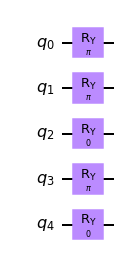

In [16]:
from qiskit import QuantumCircuit

thetas = [2*np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit((n))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)
    
init_qc.draw(output='mpl')

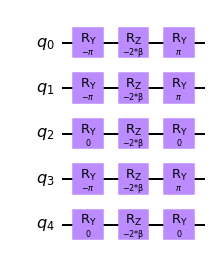

In [17]:
from qiskit.circuit import Parameter

beta = Parameter('β')

ws_mixer = QuantumCircuit(n)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2*beta, idx)
    ws_mixer.ry(theta, idx)
    
ws_mixer.draw(output='mpl')

In [18]:
ws_qaoa_mes = QAOA(quantum_instance=quantum_instance, 
                   initial_state=init_qc, 
                   mixer=ws_mixer,
                   initial_point=[0., 1.])

In [19]:
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

In [20]:
ws_qaoa_result = ws_qaoa.solve(qp)
print(ws_qaoa_result)

optimal function value: 19.0
optimal value: [1. 1. 0. 1. 0.]
status: SUCCESS


### Analysis

Both results appear to give the same result. However, when we look at the underlying probability distribution we observe that WS-QAOA has a much higher probability of sampling the optimal solution.

In [21]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        if sum(s.x) == 2:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))
        if sum(s.x) == 3:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))
        if sum(s.x) == 4:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))  
        if sum(s.x) == 5:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))    
    res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]
            
    return [(_[0] + f': value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%') for _ in res]

format_qaoa_samples(qaoa_result.samples)

#print(qaoa_result.raw_samples)

['11010: value: 19.000, probability: 16.3%',
 '00101: value: 19.000, probability: 16.3%',
 '00110: value: 17.000, probability: 1.5%',
 '11001: value: 17.000, probability: 1.5%',
 '11011: value: 16.000, probability: 3.3%',
 '10010: value: 15.000, probability: 0.7%',
 '01010: value: 15.000, probability: 5.0%',
 '10101: value: 15.000, probability: 5.0%',
 '01101: value: 15.000, probability: 0.7%',
 '11000: value: 14.000, probability: 3.9%']

In [22]:
format_qaoa_samples(ws_qaoa_result.samples)

['11010: value: 19.000, probability: 100.0%']

In [23]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

In [24]:
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True, 
                                 qaoa=qaoa_mes, epsilon=0.0)

In [25]:
ws_result = ws_qaoa.solve(qp)
ws_result

optimal function value: 19.0
optimal value: [1. 1. 0. 1. 0.]
status: SUCCESS

In [26]:
format_qaoa_samples(ws_result.samples)

['11010: value: 19.000, probability: 100.0%']